In [ ]:
!pip install -r requirements.txt

In [ ]:
!unzip minidataset.zip

In [23]:
from PIL import Image
import torch
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

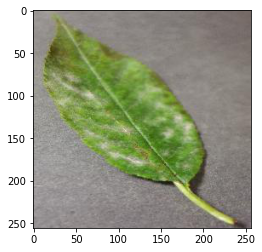

In [21]:
img_path="/content/minidataset/train/Cherry___Powdery_mildew/00b7df55-c789-43d6-a02e-a579ac9d07e6___FREC_Pwd.M 4748.JPG"
image = Image.open(img_path)
image = ToTensor()(image).unsqueeze(0) # unsqueeze to add artificial first dimension
image.size()
plt.imshow(image.permute(1, 2, 0)  )


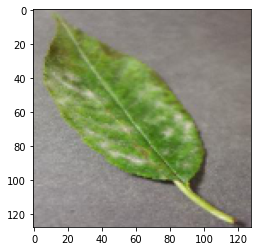

In [22]:
p = transforms.Compose([transforms.Resize((128,128))])
p(image).size()
plt.imshow(p(image).permute(1, 2, 0)  )

In [135]:
class Dataset():
    def __init__(self):
        self.labels,self.images = self.load_data()


    def load_data(self):
        labels={}
        images = {}
        count = 0
        resize = transforms.Compose([transforms.Resize((256,256))])
        main_dir = os.listdir(os.path.join("minidataset","train"))
        reference = {}
        for i,dir in enumerate(main_dir):
            reference[dir]=i
            images_list = os.listdir(os.path.join("minidataset","train",dir))
            for img in images_list:
                labels[count] = i
                img_path = os.path.join("minidataset","train",dir,img)
                image = Image.open(img_path)
                image = ToTensor()(image)
                images[count] = resize(image)
                count+=1

        print(reference)
        return labels,images
      
    def __len__(self):
        return len(self.labels)
    

    # To support the indexing such that dataset[i] can be used to get ith sample.
    def __getitem__(self, idx):
        return (
            self.images[idx],
            self.labels[idx],
        )

Tomato___Tomato_Yellow_Leaf_Curl_Virus


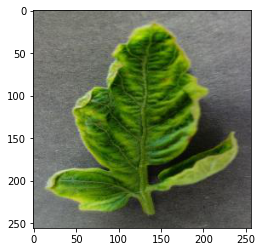

In [64]:

dataloader = torch.utils.data.DataLoader(dataset, batch_size=10,shuffle=True)
images,labels = dataset[100]
print(labels)
plt.imshow(images.permute(1, 2, 0)  )

In [124]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.conv1= nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5)
        self.conv2= nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
        
        
        self.fc1 = nn.Linear(in_features=12*61*61,out_features=120)
        self.fc2 = nn.Linear(in_features=120,out_features=60)
        self.out = nn.Linear(in_features=60,out_features=17)
        
        
    def forward(self,t):
        t = t
        
        t=self.conv1(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)
        
        
        t=self.conv2(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)
        
        #print("Here",t.size())
        t=t.reshape(-1,12*61*61)
        t=self.fc1(t)
        t=F.relu(t)
        
        
        t=self.fc2(t)
        t=F.relu(t)
        
        t=self.out(t)
        
        
        return t

In [125]:
dataset = Dataset()
model = Network()

{0: 'Potato___Early_blight', 1: 'Tomato___Early_blight', 2: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 3: 'Tomato___Bacterial_spot', 4: 'Potato___Late_blight', 5: 'Tomato___healthy', 6: 'Potato___healthy', 7: 'Tomato___Leaf_Mold', 8: 'Tomato___Target_Spot', 9: 'Tomato___Spider_mites Two-spotted_spider_mite', 10: 'Cherry___Powdery_mildew', 11: 'Tomato___Tomato_mosaic_virus', 12: 'Pepper___Bacterial_spot', 13: 'Pepper___healthy', 14: 'Tomato___Septoria_leaf_spot', 15: 'Cherry___healthy', 16: 'Tomato___Late_blight'}


In [126]:
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [133]:
def train(dataset, model):
    model.train()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_of_epochs = 5
    epochs = []
    losses = []
    for epoch in range(num_of_epochs):
        cnt = 0
        tot_loss = 0
        tot_correct = 0
        for batch, (x, y) in enumerate(dataloader):
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            y_pred = model(x)
            # Compute loss (here CrossEntropyLoss)
            loss = F.cross_entropy(y_pred,y)

            loss.backward()
            optimizer.step()

            tot_loss+=loss.item()
            tot_correct +=get_num_correct(y_pred,y)
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch",epoch,"total_correct",tot_correct,"loss:",tot_loss)

    # Plot a Validation Loss vs Epochs graph 
    plt.plot(epochs, losses, color='green', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=8) 
    plt.xlabel('epochs ---->',color='m',fontsize='xx-large' ) 
    plt.ylabel('loss ------>',color='m',fontsize='xx-large') 
    axes = plt.gca()        # 'gca' - get current axes
    axes.set_facecolor('c') #'c' - cyan
    axes.tick_params(axis='y', which='both', colors='tomato')
    axes.tick_params(axis='x', which='both', colors='#20ff14')
    plt.title("Loss vs Epoch",color='m',fontsize='xx-large')

Epoch 0 total_correct 561 loss: 28.44744712114334
Epoch 1 total_correct 705 loss: 14.598645031452179
Epoch 2 total_correct 761 loss: 9.376651793718338
Epoch 3 total_correct 804 loss: 6.086024634540081
Epoch 4 total_correct 820 loss: 4.466137304902077


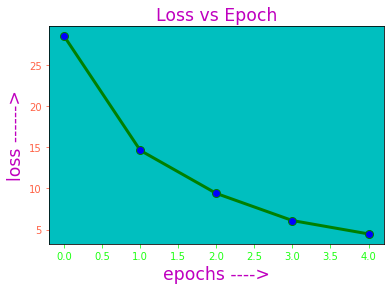

In [134]:
train(dataset, model)

In [136]:
main_dir = os.listdir(os.path.join("minidataset","train"))
reference = {}
for i,dir in enumerate(main_dir):
    reference[dir]=i
reference

{'Cherry___Powdery_mildew': 10,
 'Cherry___healthy': 15,
 'Pepper___Bacterial_spot': 12,
 'Pepper___healthy': 13,
 'Potato___Early_blight': 0,
 'Potato___Late_blight': 4,
 'Potato___healthy': 6,
 'Tomato___Bacterial_spot': 3,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 16,
 'Tomato___Leaf_Mold': 7,
 'Tomato___Septoria_leaf_spot': 14,
 'Tomato___Spider_mites Two-spotted_spider_mite': 9,
 'Tomato___Target_Spot': 8,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 2,
 'Tomato___Tomato_mosaic_virus': 11,
 'Tomato___healthy': 5}

In [137]:
#Save the trained model
torch.save(model.state_dict(), "model001_ep5.pth")

In [149]:
def predict(img_path):
    image = Image.open(img_path)
    image = ToTensor()(image)
    resize = transforms.Compose([transforms.Resize((256,256))])
    y_result = model(resize(image).unsqueeze(0))
    result_idx = y_result.argmax(dim=1)
    for key,value in reference.items():
        if(value==result_idx):
            print(key)
            break
      



In [151]:
predict("/content/minidataset/valid/Potato___Late_blight/0b2bdc8e-90fd-4bb4-bedb-485502fe8a96___RS_LB 4906.JPG")

Potato___healthy
